In [224]:
# import libraries

import numpy as np
import pandas as pd
from os.path import join
from keras.preprocessing import image
from PIL import ImageFile
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint 
from keras.utils import np_utils
from keras.applications.inception_v3 import InceptionV3
from keras import Model
import time
import matplotlib.pyplot as plt

In [116]:
# Data folder paths

train_data_folder = './files/train'
test_data_folder = './files/test'
train_data_labels = './files/labels.csv'

In [117]:
# Load labels for train data
labels = pd.read_csv(train_data_labels)
labels.sort_values(by=['id'])

# Number of breeds
count_dog_breeds = labels['breed'].nunique()  # here in Kaggle, its 120

# train data labels
# converted the labels to categorical data -- train_labels.as_matrix() gives a numpy 2D array of 
# (number of train data images)x(number of unique breeds) -- here 10222x120
train_labels = pd.get_dummies(np.array(labels['breed']))        # one-hot encoding

In [190]:
# Saving the label names of the dog breeds for the submission file
label_names = labels['breed'].sort_values().unique()

In [182]:
# sanity check step
# train_labels.as_matrix().shape

(10222, 120)

In [119]:
# sanity check 
# len(train_labels)

In [124]:
# Sanity check step
# labels.iloc[[2]]

,id,breed
2,001cdf01b096e06d78e9e5112d419397,pekinese


In [121]:
# Pre-process the Data 
# converting images into 4D Tensors in the form of (no of samples, rows, columns, channels) 
# as required by Keras using Tensorflow as backend
# channels = 3 for RGB images

# Set target of images 
image_width, image_height = 224, 224

def image_to_tensor_format(input_image):
    img = image.load_img(input_image, target_size=(image_width, image_height))
    # convert image to 3D tensor of form (224, 224, 3)
    image_tensor = image.img_to_array(img)
    # converting 3D tensor to 4D tensor as required by keras as (1, 224, 224, 3) and return
    # no of samples = 1 as for a single image
    return np.expand_dims(image_tensor, axis=0)

def train_to_tensor(image_folder):
    tensor_list = []
    for row in labels.itertuples():
        image_name = row.id + '.jpg'
        get_tensor_image = image_to_tensor_format(join(image_folder, image_name))
        if get_tensor_image is not None:
            tensor_list.append(get_tensor_image)
    return np.vstack(tensor_list)          # Stack arrays in sequence vertically (row wise)

In [123]:
# rescaling images by dividing all pixels by 255
# normalising the values from 0-1
ImageFile.LOAD_TRUNCATED_IMAGES = True     # for error handling while reading images

train_data = train_to_tensor(train_data_folder).astype('float32')/255

In [37]:
# sanity check step
# print len(train_data), len(labels)

10222 10222


In [125]:
# sanity check
# train_data[2]

array([[[ 0.39607844,  0.39215687,  0.37254903],
        [ 0.43529412,  0.43137255,  0.41176471],
        [ 0.43921569,  0.43529412,  0.41568628],
        ..., 
        [ 0.09411765,  0.05098039,  0.04705882],
        [ 0.0627451 ,  0.05882353,  0.05490196],
        [ 0.05098039,  0.05882353,  0.05490196]],

       [[ 0.3882353 ,  0.38431373,  0.36470589],
        [ 0.41176471,  0.40784314,  0.3882353 ],
        [ 0.42745098,  0.42352942,  0.40392157],
        ..., 
        [ 0.11764706,  0.07843138,  0.07450981],
        [ 0.05490196,  0.05098039,  0.04705882],
        [ 0.04313726,  0.04705882,  0.04313726]],

       [[ 0.36862746,  0.36470589,  0.34509805],
        [ 0.36078432,  0.35686275,  0.34117648],
        [ 0.39607844,  0.39215687,  0.37254903],
        ..., 
        [ 0.21568628,  0.17647059,  0.17254902],
        [ 0.07450981,  0.06666667,  0.0627451 ],
        [ 0.04705882,  0.04705882,  0.04705882]],

       ..., 
       [[ 0.76078433,  0.75686276,  0.74117649],
        

### Basic CNN Model using Keras

In [226]:
# CNN Model -- basic with only Keras (no pre-trained model)

model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (5,5), strides = (2,2), padding = 'valid', activation = 'relu', 
          input_shape = (image_width, image_height, 3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = (4,4), padding = 'valid', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=None, padding='valid'))
model.add(Conv2D(filters = 64, kernel_size = (2,2), strides = (2,2), padding = 'valid', activation = 'relu'))
model.add(GlobalAveragePooling2D())
model.add(Dense(200, activation='relu'))
model.add(Dense(count_dog_breeds, activation='softmax'))


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1805 (Conv2D)         (None, 110, 110, 16)      1216      
_________________________________________________________________
conv2d_1806 (Conv2D)         (None, 27, 27, 32)        12832     
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_1807 (Conv2D)         (None, 4, 4, 64)          8256      
_________________________________________________________________
global_average_pooling2d_26  (None, 64)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 200)               13000     
_________________________________________________________________
dense_34 (Dense)             (None, 120)               24120     
Total para

In [227]:
# Compiling the model 
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [228]:
# Training the model

# number of epochs to train the model
# one epoch = one forward pass and one backward pass of all the training examples

epochs = 5

# checkpoints to save model with minimum loss
checkpoints = ModelCheckpoint(filepath='./chkpoints/checkpoints_with_best_loss.hdf5', 
                               verbose=1, save_best_only=True)

model.load_weights('./chkpoints/checkpoints_with_best_loss.hdf5')

base_history = model.fit(train_data, train_labels.as_matrix(), validation_split=0.2, epochs=epochs, batch_size=20, 
          callbacks=[checkpoints], verbose=1)

Train on 8177 samples, validate on 2045 samples
Epoch 1/5
8177/8177 [==============================] - 292s 36ms/step - loss: 4.5571 - acc: 0.0313 - val_loss: 4.6123 - val_acc: 0.0293
Epoch 2/5
8177/8177 [==============================] - 232s 28ms/step - loss: 4.5028 - acc: 0.0356 - val_loss: 4.5905 - val_acc: 0.0318
Epoch 3/5
8177/8177 [==============================] - 229s 28ms/step - loss: 4.4491 - acc: 0.0422 - val_loss: 4.6191 - val_acc: 0.0430
Epoch 4/5
8177/8177 [==============================] - 218s 27ms/step - loss: 4.3974 - acc: 0.0456 - val_loss: 4.4792 - val_acc: 0.0450
Epoch 5/5
8177/8177 [==============================] - 223s 27ms/step - loss: 4.3494 - acc: 0.0492 - val_loss: 4.4936 - val_acc: 0.0460


In [229]:
print(base_history.history.keys()) 

['acc', 'loss', 'val_acc', 'val_loss']


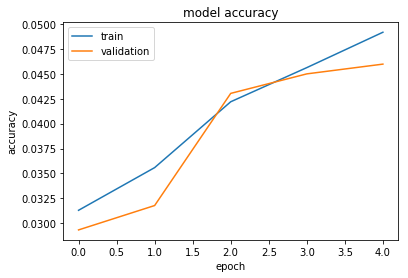

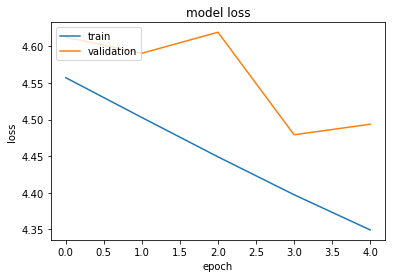

In [230]:
#  "Accuracy"
plt.plot(base_history.history['acc'])
plt.plot(base_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(base_history.history['loss'])
plt.plot(base_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### CNN Model using Transfer Learning

In [237]:
# Finding bottlenecks features for Inception model
# Bottleneck features is getting the remaining of the pre-trained model after removing the final layers
# here include_top=False removes the last layer of Inception

base_model = InceptionV3(weights='imagenet', include_top=False)
# adding our own layers
inception_model = Sequential()
inception_model.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:]))
inception_model.add(Dense(count_dog_breeds, activation='softmax')) 
inception_model = Model(inputs=base_model.input, outputs=inception_model(base_model.output))

In [238]:
# Freezing the inception model layers to be trained
for layer in base_model.layers:
    layer.trainable = False

# Compiling the model 
inception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [239]:
# Model training
epochs = 5

checkpointes_incptn = ModelCheckpoint(filepath='./chkpoints/checkpoints_with_best_loss_inception.hdf5', 
                               verbose=1, save_best_only=True)

inception_model.load_weights('./chkpoints/checkpoints_with_best_loss_inception.hdf5')

inception_history = inception_model.fit(train_data, train_labels.as_matrix(), validation_split=0.2, 
                                        epochs=epochs, batch_size=20, callbacks=[checkpointes_incptn], verbose=1)

Train on 8177 samples, validate on 2045 samples
Epoch 1/5
8177/8177 [==============================] - 3846s 470ms/step - loss: 1.3347 - acc: 0.6445 - val_loss: 1.5284 - val_acc: 0.6337
Epoch 2/5
8177/8177 [==============================] - 3567s 436ms/step - loss: 1.1761 - acc: 0.6800 - val_loss: 1.5993 - val_acc: 0.6220
Epoch 3/5
8177/8177 [==============================] - 4993s 611ms/step - loss: 1.1038 - acc: 0.7023 - val_loss: 1.6574 - val_acc: 0.6333
Epoch 4/5
8177/8177 [==============================] - 3330s 407ms/step - loss: 1.0211 - acc: 0.7256 - val_loss: 1.6916 - val_acc: 0.6269
Epoch 5/5
8177/8177 [==============================] - 4656s 569ms/step - loss: 0.9593 - acc: 0.7357 - val_loss: 1.6556 - val_acc: 0.6401


['acc', 'loss', 'val_acc', 'val_loss']


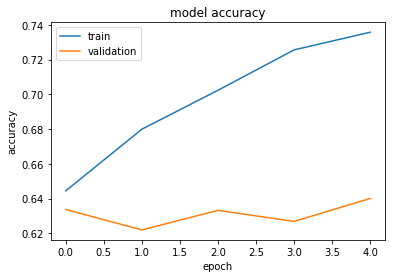

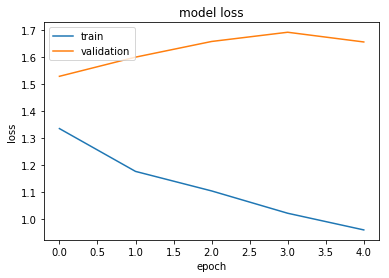

In [242]:
print(inception_history.history.keys())
#  "Accuracy"
plt.plot(inception_history.history['acc'])
plt.plot(inception_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(inception_history.history['loss'])
plt.plot(inception_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [243]:
# Load model weights with best validation loss.
inception_model.load_weights('./chkpoints/checkpoints_with_best_loss_inception.hdf5')

In [244]:
# Test data --> convert images to tensors and writing to submission file

out_file = './submissions/submission_' + str(int(time.time())) + '.csv'
out_file = open(out_file, 'w')
out_file.write("id,")
out_file.write(','.join([l for l in label_names]) + '\n')
for f in os.listdir(test_data_folder):
    image_id = os.path.splitext(f)[0]        # image filename as id
    # convert the image to 4D tensor
    image_tensor = image_to_tensor_format(join(test_data_folder, f)).astype('float32')/255
    image_prediction = inception_model.predict(image_tensor, batch_size=32, verbose=1)
    out_file.write(image_id+',')
    out_file.write(','.join([format(float(i), '.17f') for i in np.nditer(image_prediction)]) + '\n')
out_file.close()

1/1 [==============================] - 0s 406ms/step


1/1 [==============================] - 0s 382ms/step


1/1 [==============================] - 0s 369ms/step


1/1 [==============================] - 0s 361ms/step


1/1 [==============================] - 0s 360ms/step


1/1 [==============================] - 0s 356ms/step


1/1 [==============================] - 0s 356ms/step


1/1 [==============================] - 0s 378ms/step


1/1 [==============================] - 0s 361ms/step


1/1 [==============================] - 0s 399ms/step


1/1 [==============================] - 0s 421ms/step


1/1 [==============================] - 0s 381ms/step


1/1 [==============================] - 0s 410ms/step


1/1 [==============================] - 0s 448ms/step


1/1 [==============================] - 0s 479ms/step


1/1 [==============================] - 0s 382ms/step


1/1 [==============================] - 0s 373ms/step


1/1 [==============================] - 0s 380ms/step


1/1 [==============================] - 0s 394ms/step


1/1 [==============================] - 0s 454ms/step


1/1 [==============================] - 1s 641ms/step


1/1 [==============================] - 0s 472ms/step


1/1 [==============================] - 0s 456ms/step


1/1 [==============================] - 1s 519ms/step


1/1 [==============================] - 1s 536ms/step


1/1 [==============================] - 0s 382ms/step


1/1 [==============================] - 0s 381ms/step


1/1 [==============================] - 0s 357ms/step


1/1 [==============================] - 0s 361ms/step


1/1 [==============================] - 0s 356ms/step


1/1 [==============================] - 0s 363ms/step


1/1 [==============================] - 0s 439ms/step


1/1 [==============================] - 0s 372ms/step


1/1 [==============================] - 0s 364ms/step


1/1 [==============================] - 0s 376ms/step


1/1 [==============================] - 0s 369ms/step


1/1 [==============================] - 0s 357ms/step


1/1 [==============================] - 0s 420ms/step


1/1 [==============================] - 0s 395ms/step


1/1 [==============================] - 0s 362ms/step


1/1 [==============================] - 0s 376ms/step


1/1 [==============================] - 0s 376ms/step


1/1 [==============================] - 0s 379ms/step


1/1 [==============================] - 0s 403ms/step


1/1 [==============================] - 0s 361ms/step


1/1 [==============================] - 1s 511ms/step


1/1 [==============================] - 0s 407ms/step


1/1 [==============================] - 0s 353ms/step


1/1 [==============================] - 0s 381ms/step


1/1 [==============================] - 0s 362ms/step


1/1 [==============================] - 0s 364ms/step


1/1 [==============================] - 0s 373ms/step


1/1 [==============================] - 0s 355ms/step


1/1 [==============================] - 0s 362ms/step


1/1 [==============================] - 0s 368ms/step


1/1 [==============================] - 0s 366ms/step


1/1 [==============================] - 0s 369ms/step


1/1 [==============================] - 0s 405ms/step


1/1 [==============================] - 0s 379ms/step


1/1 [==============================] - 0s 360ms/step


1/1 [==============================] - 0s 396ms/step


1/1 [==============================] - 0s 359ms/step


1/1 [==============================] - 0s 488ms/step


1/1 [==============================] - 0s 431ms/step


1/1 [==============================] - 0s 418ms/step


1/1 [==============================] - 0s 417ms/step


1/1 [==============================] - 0s 384ms/step


In [267]:
# Predictions on test images

top_n = 3

def predict_dog_breed(image_path):
    
    # convert image to tensor
    image_tensor = image_to_tensor_format(image_path).astype('float32')/255
    
    # Predict using the model
    image_prediction = inception_model.predict(image_tensor, batch_size=32, verbose=1)
    print image_prediction
    predicted_breeds = [label_names[idx] for idx in image_prediction.argsort()[-3:][::-1]]
    predicted_confidence = image_prediction.argsort()[-3:][::-1]

    return predicted_breeds, predicted_confidence

def get_prediction(image_path):
    predicted_breeds, predicted_confidence = predict_dog_breed(image_path)
    print predicted_breeds, predicted_confidence
    print('Top 3 predictions:')
    for i, j in zip(predicted_breeds, predicted_confidence):
        print('Predicted breed: {} with a confidence of {:.4f}'.format(i, float(j)))

In [ ]:
get_prediction('./test_images/Boxer.jpg')